In [1]:
import os
import h5py

import argparse
import errno

import numpy as np
import scipy

import matplotlib.pyplot as plt
%matplotlib widget

In [2]:
path = '/home/lorenzo/phd/DePietri/NS_HOT_EOS/EOS/compOSE/FOP(SFHoY)we/'
INPUT = path + 'FOP(SFHoY)we.h5'

table = {}
with h5py.File(INPUT, "r") as f:
    for key in f.keys():
        table[key] = f[key][()]

print(table.keys())

dict_keys(['X12H', 'X13H', 'X23He', 'X24He', 'Xe', 'Xn', 'Xother', 'Xp', 'XΛ', 'XΞ0', 'XΞ−', 'XΣ+', 'XΣ0', 'XΣ−', 'cs2', 'energy_shift', 'entropy', 'free_energy', 'gamma', 'logenergy', 'logpress', 'logrho', 'logtemp', 'mu_12H', 'mu_13H', 'mu_23He', 'mu_24He', 'mu_e', 'mu_n', 'mu_p', 'mu_Λ', 'mu_Ξ0', 'mu_Ξ−', 'mu_Σ+', 'mu_Σ0', 'mu_Σ−', 'munu', 'pointsrho', 'pointstemp', 'pointsyq', 'ye'])


In [3]:
interp_e = scipy.interpolate.RectBivariateSpline(np.array(table['ye']),np.array(table['logrho']),np.array(table['logenergy'][:,0,:]))
interp_p = scipy.interpolate.RectBivariateSpline(np.array(table['ye']),np.array(table['logrho']),np.array(table['logpress'][:,0,:]))
interp_munu = scipy.interpolate.RectBivariateSpline(np.array(table['ye']),np.array(table['logrho']),np.array(table['munu'][:,0,:]))
interp_F = scipy.interpolate.RectBivariateSpline(np.array(table['ye']),np.array(table['logrho']),np.array(table['free_energy'][:,0,:]))
def f_F(x, rho, interp_F):
    return interp_F(x, rho)

In [4]:
# ------------------------------------------------------------------------
G     = 6.6738e-11     # m^3/(kg s^2)
c     = 299792458.0     # m/s
hbar = 1.054571817e-34  # J s
cCGS  = 299792458.0*100 # cm/s
M_sun = 1.9885e30       # kg
mu0   = 1.256637061435917e-6 # Newton/Ampere^2
                        # 4*\pi*1e-7
Kb      = 1.3806488e-23     # Joule/K
Mparsec = 3.08567758e19     # km
eV      = 1.6021766208e-19  # Joule
MeV     = 1.6021766208e-13  # Joule
MeVCGS  = 1.6021766208e-6   # g cm^2/s^2
fermi   = 1e-15             # metri
fermiCGS= 1e-13             # metri
##----------------------------------
## The Barion Mass used by RNS
##----------------------------------
Mbaryon    = 1.66e-27     # kg
#-------------------------------------------
# conversion factors
#-------------------------------------------
CU_to_kg   = M_sun                               # kg
CU_to_s    = (M_sun*G/(c*c*c))                   # s
CU_to_m    = M_sun*G/(c*c)                       # m
CU_to_dens = c*c*c*c*c*c / (G*G*G * M_sun*M_sun) # kg/m^3
CU_to_press= c**6 / (G**3 * M_sun**2) *c**2      # kg m/s^2 /m^2
CU_to_Tesla =c**4 / M_sun / G**(1.5)* mu0**(0.5)
CU_to_Gauss =c**4 / M_sun / G**(1.5)* mu0**(0.5) * 10000
CU_to_energy    = M_sun*c*c                # kg m^2/s^2
######## Usefull #############################################
CU_to_km   = CU_to_m/1000                   # km
CU_to_ms   = 1000*CU_to_s                   # ms
########### CGS ############################################## 
MbaryonCGS      = Mbaryon*1000              # g
CU_to_cm        = CU_to_km * 1000 * 100     # cm
CU_to_g         = CU_to_kg * 1000           # g
CU_to_energyCGS = CU_to_energy *1000*100**2 # g cm^2/s^2
CU_to_densCGS   = CU_to_dens   *1000/100**3 # g/cm^3
CU_to_pressCGS  = CU_to_press  *1000/100    # g /s^2 / cm
# ------------------------------------------------------------
# All expeession in CU refer to unit mass (a-dimensional) 
# where G=c=M_sun=1
# ------------------------------------------------------------

#--------------------------------------------------------------------
# ORIGINAL RNS values
#--------------------------------------------------------------------

RNS_c     = 2.9979e10
RNS_G     = 6.6732e-8
RNS_MB    = 1.66e-24
RNS_M_sun = 1.987e33
CU_RNS_to_dens  = RNS_c**6 / (RNS_G**3 * RNS_M_sun**2)
CU_RNS_to_press = RNS_c**6 / (RNS_G**3 * RNS_M_sun**2) *RNS_c**2


In [5]:
# Open file
fout=open('FOP(SFHoY)we_minF_lorene.d','w')
# Write header
fout.write('#\n#\n#\n#\n#\n')
fout.write('%d <-------number of lines\n'% 5000)
fout.write('#\n# n_B[fm^-3] rho[g/cm^3] p[dyn/cm^2] \n#\n')

lrhomin = table['logrho'][0]
lrhomax = table['logrho'][-1]
ldrho   = (lrhomax - lrhomin) / 4999

# Atomic mass unit --> mass of nucleon
mb = 1.66e-24 # grams

for i in range(5000):
    # Step through the densities
    lrho_tmp = (lrhomin+i*ldrho)
    ye_tmp = scipy.optimize.minimize(f_F, [np.min(table['free_energy'][:, 0, :])], args = (lrho_tmp, interp_F)).x

    # Compute energy, pressure and density via interpolation at this Y_e
    # e[g/cm^3] = rho[g/cm^3] * (eps[erg/g]/c^2 + 1)
    e_tmp = 10**lrho_tmp*((10**interp_e(ye_tmp,lrho_tmp)[0][0] - table['energy_shift']) / (c**2*10000) + 1) 
    p_tmp = 10**interp_p(ye_tmp,lrho_tmp)[0][0]
    nb_tmp = 10**lrho_tmp/mb/1e39 # g / cm^3 / g = 1/cm^3 --> 1 m = 1e2 cm = 1e15 fm --> 1 cm^-3 = (1e13 fm)^-3 = 1e-39 fm^-3
    
    fout.write('%d   %1.8e    %1.8e    %1.8e\n' %(i+1,nb_tmp,e_tmp,p_tmp))

fout.close()

In [6]:
#Utility function for munu zero finding for imposing beta equilibrium
def f_munu(y, rho, table):
    interpmunu = scipy.interpolate.RectBivariateSpline(np.array(table['ye']),np.array(table['logrho']),np.array(table['munu'][:,0,:])) 
    return interpmunu(y, rho)


#Reads Finite Temperature EOS tables from stellarcollapse.org and 
#converts them in the out_format, imposing beta equilibrium 
#Right now the options are:
#out_format='lorene', out_format='rns' and out_format='ascii'(slow)


def ReadOttTable(file_in, nrows=5000, rhomin=5e6, rhomax=5e15, T=0.01, ye=0.15, beta_eq=True, out_format="ascii"):
    # Open stellarcollapse.h5
    table = h5py.File(file_in)

    # Determine name of new table
    name = os.path.split(file_in)[1]
    name = os.path.splitext(name)[0]
    print (name)

    # Compute log_10 of min and max density and the spacing
    lrhomin = np.log10(rhomin)
    lrhomax = np.log10(rhomax)
    ldrho   = (lrhomax-lrhomin)/(nrows-1)   
  
    # Atomic mass unit --> mass of nucleon
    mb = 1.66e-24   
    #Imposing beta equilibrium  
    if out_format=='lorene':    
        # Open file
        fout=open(name+'_lorene.d','w')
        # Write header
        fout.write('#\n#\n#\n#\n#\n')
        fout.write('%d <-------number of lines\n'% nrows)
        fout.write('#\n# n_B[fm^-3] rho[g/cm^3] p[dyn/cm^2] \n#\n')
        
        
        interp_e = scipy.interpolate.RectBivariateSpline(np.array(table['ye']),np.array(table['logrho']),np.array(table['logenergy'][:,0,:]))
        interp_p = scipy.interpolate.RectBivariateSpline(np.array(table['ye']),np.array(table['logrho']),np.array(table['logpress'][:,0,:]))
        interp_munu = scipy.interpolate.RectBivariateSpline(np.array(table['ye']),np.array(table['logrho']),np.array(table['munu'][:,0,:])) 
        for i in range(nrows):
            # Step through the densities
            lrho_tmp = (lrhomin+i*ldrho)
            
            # Find the zero of table['munu'] at fixed denisity and T = 0 --> find Y_e of beta equilibrium.
            # munu = (mu_e - mu_n + mu_p)
            # This is because, in a beta-stable system, the weak interactions among the particles can change a neutron into a proton, an electron and an anti-neutrino (or vice versa). In order for this process to happen at a steady state, the chemical potential of the neutron must be equal to the chemical potential of the proton plus the chemical potential of the electron. This is written as mu_n = mu_p + mu_e. 
            # So, munu = mu_e - mu_n + mu_p = mu_e - (mu_p + mu_e) + mu_p = 0, meaning that all the chemical potentials are equal in a beta-stable system, therefore no net flow of these particles between regions of different chemical potential.
            ye_tmp = scipy.optimize.brentq(f_munu, 0.01, 0.65, args = (lrho_tmp, table), maxiter=200)
            
            # Compute energy, pressure and density via interpolation at this Y_e
            e_tmp = 10**lrho_tmp* ((10**interp_e(ye_tmp,lrho_tmp)[0][0] - table['energy_shift']) / (c**2*10000) + 1)
            p_tmp = 10**interp_p(ye_tmp,lrho_tmp)[0][0]
            nb_tmp = 10**lrho_tmp/mb/1e39
                        
            fout.write('%d   %1.8e    %1.8e    %1.8e\n' %(i+1,nb_tmp,e_tmp,p_tmp))        
        
        fout.close()

In [7]:
file_in = '/home/lorenzo/phd/DePietri/NS_HOT_EOS/EOS/compOSE/FOP(SFHoY)we/FOP(SFHoY)we.h5'
ReadOttTable(file_in, rhomin=10**table['logrho'][0], rhomax=10**table['logrho'][-1], out_format='lorene')

FOP(SFHoY)we


In [8]:
minF = np.loadtxt('/home/lorenzo/phd/DePietri/NS_HOT_EOS/Notebooks/FOP(SFHoY)we_minF_lorene.d', skiprows=9)
zerM = np.loadtxt('/home/lorenzo/phd/DePietri/NS_HOT_EOS/Notebooks/FOP(SFHoY)we_lorene.d', skiprows=9)

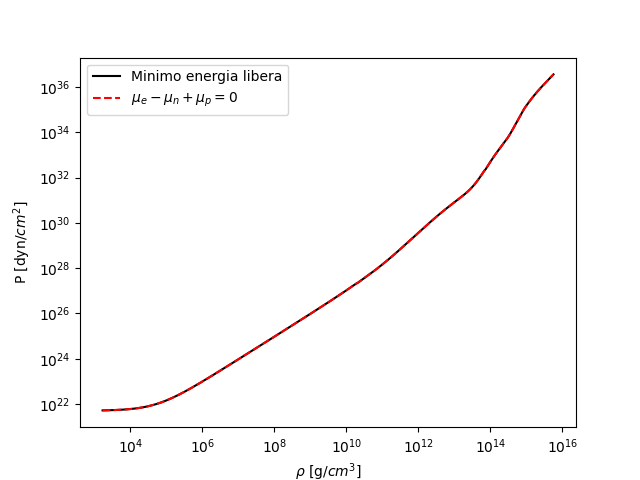

In [9]:
fig = plt.figure()
plt.plot(minF[:,2], minF[:,3], color = 'k', label = 'Minimo energia libera')
plt.plot(zerM[:,2], zerM[:,3], color = 'r', ls = '--', label = r'$\mu_e - \mu_n + \mu_p = 0$')

plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'$\rho$ [g/$cm^3$]')
plt.ylabel(r'P [dyn/$cm^2$]')

plt.legend()
plt.show()